In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
 
data_transfrom = transforms.Compose([  # 对读取的图片进行以下指定操作
    transforms.ToTensor(),             # 向量化,向量化时 每个点的像素值会除以255,整个向量中的元素值都在0-1之间      
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((300, 300)),# 图片放缩为 (300, 300), 统一处理的图像最好设置为统一的大小,这样之后的处理也更加方便
])

batch_size = 4
 
trainset = datasets.ImageFolder('./OCT_data/train', transform=data_transfrom)  # 指明读取的文件夹和读取方式,注意指明的是到文件夹的路径,不是到图片的路径
 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)  # 指定读取配置信息

testset = datasets.ImageFolder('./OCT_data/test', transform=data_transfrom)  # 指明读取的文件夹和读取方式,注意指明的是到文件夹的路径,不是到图片的路径
 
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1)

classes = ('AMD', 'DR', 'NORMAL')


In [3]:
# inputs, labels = next(iter(trainloader))
# print(labels[0].item())           # 打印返回的值
# inputs = inputs / 2 + 0.5    # 使得整个图像的像素值都在0.5之上，使得处理后的图像偏白
# inputs = torchvision.utils.make_grid(inputs)   # make_grid()实现图片的拼接，并去除原本Tesor中Batch_Size那一维度,因为操作之前的inputs是4维的, make_grid()返回的结果是3维的, shape为(3, h, w) 3代表通道数, w,h代表拼接后图片的宽高
# inputs = inputs.numpy().transpose((1, 2, 0))   # transpose((1, 2, 0)) 是将(3, h, w) 变为 (h ,w, 3), 因为这种格式才是图像存储的标准格式
# plt.imshow(inputs)           # 展示,这里会一块展示batch_size张图片,因为它们是一块被读出来的
# plt.show()
# labels

In [4]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batch_size = 4

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
print(trainset)

Dataset ImageFolder
    Number of datapoints: 280
    Root location: ./OCT_data/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=None)
           )


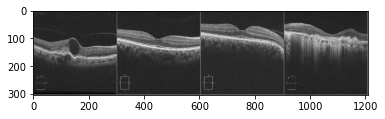

AMD   NORMAL NORMAL AMD  


tensor([0, 2, 2, 0])

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
labels

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)
        self.fc1 = nn.Linear(82944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

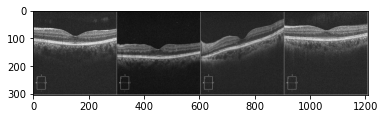

GroundTruth:  NORMAL DR    DR    NORMAL


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
outputs = net(images)

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  NORMAL DR    DR    NORMAL


In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 78 %


In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: AMD   is 0.0 %
Accuracy for class: DR    is 88.9 %
Accuracy for class: NORMAL is 97.8 %


In [17]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# # Assuming that we are on a CUDA machine, this should print a CUDA device:

# print(device)